In [1]:
# before any Mal-ID imports, we need to configure our environment to use the special leave-one-cohort-out split
import os

os.environ["MALID_CV_SPLIT"] = "in_house_peak_disease_leave_one_cohort_out"

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import genetools
from IPython.display import display, Markdown
from typing import List, Tuple, Dict, Optional
import gc

from malid import config, io
from malid.trained_model_wrappers import BlendingMetamodel
import crosseval
from crosseval import FeaturizedData
from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    healthy_label,
    CrossValidationSplitStrategy,
)

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error

In [3]:
assert (
    config.cross_validation_split_strategy
    == CrossValidationSplitStrategy.in_house_peak_disease_leave_one_cohort_out
)

## Load data, and figure out how we will separate healthy resequenced samples by replicate.

In [4]:
adata_bcr = io.load_fold_embeddings(
    fold_id=0,
    fold_label="test",
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease,
)
adata_bcr

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_leave_one_cohort_out/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/ebce2e41549aaa8d812a3131587aece1eab03ea5885d8abfb78f0fb0.0.test.h5ad", "time": "2024-02-22T02:01:32.826453"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


AnnData object with n_obs × n_vars = 1855605 × 640
    obs: 'amplification_label', 'v_gene', 'j_gene', 'disease', 'fr1_seq_aa_q_trim', 'cdr1_seq_aa_q_trim', 'fr2_seq_aa_q_trim', 'cdr2_seq_aa_q_trim', 'fr3_seq_aa_q_trim', 'cdr3_seq_aa_q_trim', 'post_seq_aa_q_trim', 'cdr3_aa_sequence_trim_len', 'extracted_isotype', 'isotype_supergroup', 'v_mut', 'num_reads', 'igh_or_tcrb_clone_id', 'total_clone_num_reads', 'num_clone_members', 'specimen_label', 'past_exposure', 'disease.separate_past_exposures', 'disease.rollup', 'v_family', 'sample_weight_isotype_rebalance', 'sample_weight_clone_size', 'study_name', 'participant_label', 'specimen_time_point', 'disease_subtype', 'age', 'sex', 'ethnicity_condensed', 'age_group', 'age_group_binary', 'age_group_pediatric', 'disease_severity', 'specimen_description', 'symptoms_IBD_Disease duration (yrs)', 'symptoms_IBD_Disease for ≥15 years?', 'symptoms_IBD_Disease location', 'symptoms_IBD_Estraintestinal manifestations?', 'symptoms_IBD_Flare/Remission', 'sy

In [5]:
adata_tcr = io.load_fold_embeddings(
    fold_id=0,
    fold_label="test",
    gene_locus=GeneLocus.TCR,
    target_obs_column=TargetObsColumnEnum.disease,
)
adata_tcr

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_leave_one_cohort_out/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/7496e07e00cf5f06671eb467c4152a1424dbc9d0850c35e420f1a775.0.test.h5ad", "time": "2024-02-22T02:02:01.281669"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


AnnData object with n_obs × n_vars = 2356797 × 640
    obs: 'amplification_label', 'v_gene', 'j_gene', 'disease', 'fr1_seq_aa_q_trim', 'cdr1_seq_aa_q_trim', 'fr2_seq_aa_q_trim', 'cdr2_seq_aa_q_trim', 'fr3_seq_aa_q_trim', 'cdr3_seq_aa_q_trim', 'post_seq_aa_q_trim', 'cdr3_aa_sequence_trim_len', 'extracted_isotype', 'isotype_supergroup', 'v_mut', 'num_reads', 'igh_or_tcrb_clone_id', 'total_clone_num_reads', 'num_clone_members', 'specimen_label', 'past_exposure', 'disease.separate_past_exposures', 'disease.rollup', 'v_family', 'sample_weight_isotype_rebalance', 'sample_weight_clone_size', 'study_name', 'participant_label', 'specimen_time_point', 'disease_subtype', 'age', 'sex', 'ethnicity_condensed', 'age_group', 'age_group_binary', 'age_group_pediatric', 'disease_severity', 'specimen_description', 'symptoms_IBD_Disease duration (yrs)', 'symptoms_IBD_Disease for ≥15 years?', 'symptoms_IBD_Disease location', 'symptoms_IBD_Estraintestinal manifestations?', 'symptoms_IBD_Flare/Remission', 'sy

In [6]:
adata_bcr.obs.drop_duplicates("specimen_label")["disease"].value_counts()

Healthy/Background    30
Covid19               10
Name: disease, dtype: int64

In [7]:
# healthy example:
adata_bcr.obs[adata_bcr.obs["specimen_label"] == "M64-081"][
    "amplification_label"
].cat.remove_unused_categories().value_counts()

M66-M64-081_cDNA_PCR     137432
M479-M64-081_cDNA_PCR     25920
Name: amplification_label, dtype: int64

In [8]:
# Covid has single amplification
adata_bcr.obs[adata_bcr.obs["specimen_label"] == "M371-S004"][
    "amplification_label"
].nunique()

1

In [9]:
# proof: Covid has single amplification, healthy has two amplifications (original and resequencing)
adata_bcr.obs.groupby(["disease", "specimen_label"], observed=True)[
    "amplification_label"
].nunique()

disease             specimen_label
Healthy/Background  M64-012           2
                    M64-033           2
                    M64-035           2
                    M64-037           2
                    M64-038           2
                    M64-043           2
                    M64-044           2
                    M64-048           2
                    M64-049           2
                    M64-051           2
                    M64-052           2
                    M64-054           2
                    M64-055           2
                    M64-057           2
                    M64-060           2
                    M64-061           2
                    M64-063           2
                    M64-064           2
                    M64-065           2
                    M64-068           2
                    M64-069           2
                    M64-073           2
                    M64-075           2
                    M64-080           2
     

In [10]:
# Rename specimens using the amplification label, so we can separate the healthy replicates.

In [11]:
pd.set_option("display.max_columns", None)
adata_bcr.obs.groupby(["specimen_label", "amplification_label"], observed=True).size()

specimen_label  amplification_label  
M369-S001       M369-S001_cDNA_PCR        55543
M371-S004       M371-S004_cDNA_PCR         3759
M371-S005       M371-S005_cDNA_PCR        18339
M371-S009       M371-S009_cDNA_PCR         8275
M371-S011       M371-S011_cDNA_PCR        13663
                                          ...  
M64-091         M66-M64-091_cDNA_PCR     104554
                M479-M64-091_cDNA_PCR     13161
M64-093         M66-M64-093_cDNA_PCR      53051
                M479-M64-093_cDNA_PCR      3369
M64-097         M66-M64-097_cDNA_PCR     100595
Length: 69, dtype: int64

In [12]:
adata_bcr.obs[adata_bcr.obs["disease"] == healthy_label][
    "amplification_label"
].unique().tolist()

['M66-M64-012_cDNA_PCR',
 'M477-M64-012_cDNA_PCR',
 'M66-M64-033_cDNA_PCR',
 'M477-M64-033_cDNA_PCR',
 'M66-M64-035_cDNA_PCR',
 'M477-M64-035_cDNA_PCR',
 'M66-M64-037_cDNA_PCR',
 'M477-M64-037_cDNA_PCR',
 'M66-M64-038_cDNA_PCR',
 'M477-M64-038_cDNA_PCR',
 'M66-M64-043_cDNA_PCR',
 'M477-M64-043_cDNA_PCR',
 'M66-M64-044_cDNA_PCR',
 'M477-M64-044_cDNA_PCR',
 'M66-M64-048_cDNA_PCR',
 'M477-M64-048_cDNA_PCR',
 'M66-M64-049_cDNA_PCR',
 'M477-M64-049_cDNA_PCR',
 'M66-M64-051_cDNA_PCR',
 'M477-M64-051_cDNA_PCR',
 'M66-M64-052_cDNA_PCR',
 'M477-M64-052_cDNA_PCR',
 'M66-M64-054_cDNA_PCR',
 'M477-M64-054_cDNA_PCR',
 'M66-M64-055_cDNA_PCR',
 'M477-M64-055_cDNA_PCR',
 'M66-M64-057_cDNA_PCR',
 'M479-M64-057_cDNA_PCR',
 'M66-M64-060_cDNA_PCR',
 'M479-M64-060_cDNA_PCR',
 'M66-M64-061_cDNA_PCR',
 'M479-M64-061_cDNA_PCR',
 'M66-M64-063_cDNA_PCR',
 'M479-M64-063_cDNA_PCR',
 'M66-M64-064_cDNA_PCR',
 'M477-M64-064_cDNA_PCR',
 'M66-M64-065_cDNA_PCR',
 'M477-M64-065_cDNA_PCR',
 'M66-M64-068_cDNA_PCR',
 'M479

In [13]:
adata_tcr.obs[adata_tcr.obs["disease"] == healthy_label][
    "amplification_label"
].unique().tolist()

['M64-012_cDNA_TCRB',
 'M477-M64-012_cDNA_PCR_TCRB',
 'M64-033_cDNA_TCRB',
 'M477-M64-033_cDNA_PCR_TCRB',
 'M64-035_cDNA_TCRB',
 'M477-M64-035_cDNA_PCR_TCRB',
 'M64-037_cDNA_TCRB',
 'M477-M64-037_cDNA_PCR_TCRB',
 'M64-038_cDNA_TCRB',
 'M477-M64-038_cDNA_PCR_TCRB',
 'M64-043_cDNA_TCRB',
 'M477-M64-043_cDNA_PCR_TCRB',
 'M64-044_cDNA_TCRB',
 'M477-M64-044_cDNA_PCR_TCRB',
 'M64-048_cDNA_TCRB',
 'M477-M64-048_cDNA_PCR_TCRB',
 'M64-049_cDNA_TCRB',
 'M477-M64-049_cDNA_PCR_TCRB',
 'M64-051_cDNA_TCRB',
 'M477-M64-051_cDNA_PCR_TCRB',
 'M64-052_cDNA_TCRB',
 'M477-M64-052_cDNA_PCR_TCRB',
 'M64-054_cDNA_TCRB',
 'M477-M64-054_cDNA_PCR_TCRB',
 'M64-055_cDNA_TCRB',
 'M477-M64-055_cDNA_PCR_TCRB',
 'M64-057_cDNA_TCRB',
 'M479-M64-057_cDNA_PCR_TCRB',
 'M64-060_cDNA_TCRB',
 'M479-M64-060_cDNA_PCR_TCRB',
 'M64-061_cDNA_TCRB',
 'M479-M64-061_cDNA_PCR_TCRB',
 'M64-063_cDNA_TCRB',
 'M479-M64-063_cDNA_PCR_TCRB',
 'M64-064_cDNA_TCRB',
 'M477-M64-064_cDNA_PCR_TCRB',
 'M64-065_cDNA_TCRB',
 'M477-M64-065_cDNA_PCR_

In [14]:
adata_bcr.obs[adata_bcr.obs["disease"] != healthy_label][
    "amplification_label"
].unique().tolist()

['M369-S001_cDNA_PCR',
 'M371-S004_cDNA_PCR',
 'M371-S031_cDNA_PCR',
 'M371-S015_cDNA_PCR',
 'M371-S005_cDNA_PCR',
 'M371-S023_cDNA_PCR',
 'M371-S024_cDNA_PCR',
 'M371-S009_cDNA_PCR',
 'M371-S011_cDNA_PCR',
 'M371-S028_cDNA_PCR']

In [15]:
adata_tcr.obs[adata_tcr.obs["disease"] != healthy_label][
    "amplification_label"
].unique().tolist()

['M369-S001_cDNA_PCR_TCRB',
 'M371-S004_cDNA_PCR_TCRB',
 'M371-S031_cDNA_PCR_TCRB',
 'M371-S015_cDNA_PCR_TCRB',
 'M371-S005_cDNA_PCR_TCRB',
 'M371-S023_cDNA_PCR_TCRB',
 'M371-S024_cDNA_PCR_TCRB',
 'M371-S009_cDNA_PCR_TCRB',
 'M371-S011_cDNA_PCR_TCRB',
 'M371-S028_cDNA_PCR_TCRB']

In [16]:
# Set extracted_replicate_label column based on amplification_label, which is slightly different in BCR vs TCR data
# We will unify them here carefully
adata_tcr.obs["extracted_replicate_label"] = (
    adata_tcr.obs["amplification_label"]
    .str.replace("_cDNA.*TCRB", "")
    .apply(lambda x: f"M66-{x}" if len(x.split("-")) == 2 else x)
)


adata_bcr.obs["extracted_replicate_label"] = (
    adata_bcr.obs["amplification_label"]
    .str.replace("_cDNA_PCR", "")
    .apply(lambda x: f"M66-{x}" if len(x.split("-")) == 2 else x)
)

{"message": "/tmp/ipykernel_2983587/1168597997.py:4: FutureWarning: The default value of regex will change from True to False in a future version.\n  adata_tcr.obs[\"amplification_label\"]\n", "time": "2024-02-22T02:02:46.952372"}


In [17]:
# Review results.

In [18]:
adata_bcr.obs[
    ["amplification_label", "extracted_replicate_label"]
].drop_duplicates().sort_values("extracted_replicate_label")

,amplification_label,extracted_replicate_label
__null_dask_index__,,
159490,M477-M64-012_cDNA_PCR,M477-M64-012
133942,M477-M64-033_cDNA_PCR,M477-M64-033
132896-1,M477-M64-035_cDNA_PCR,M477-M64-035
121253,M477-M64-037_cDNA_PCR,M477-M64-037
207844,M477-M64-038_cDNA_PCR,M477-M64-038
...,...,...
14912-7,M66-M64-084_cDNA_PCR,M66-M64-084
0-13,M66-M64-087_cDNA_PCR,M66-M64-087
8140-11,M66-M64-091_cDNA_PCR,M66-M64-091


In [19]:
adata_tcr.obs[
    ["amplification_label", "extracted_replicate_label"]
].drop_duplicates().sort_values("extracted_replicate_label")

,amplification_label,extracted_replicate_label
__null_dask_index__,,
273507,M477-M64-012_cDNA_PCR_TCRB,M477-M64-012
225493-1,M477-M64-033_cDNA_PCR_TCRB,M477-M64-033
232707-1,M477-M64-035_cDNA_PCR_TCRB,M477-M64-035
220031,M477-M64-037_cDNA_PCR_TCRB,M477-M64-037
377932,M477-M64-038_cDNA_PCR_TCRB,M477-M64-038
...,...,...
186297-9,M64-084_cDNA_TCRB,M66-M64-084
219123-10,M64-087_cDNA_TCRB,M66-M64-087
313966-5,M64-091_cDNA_TCRB,M66-M64-091


In [20]:
# This one was present in TCR but not in BCR:
set(adata_tcr.obs.extracted_replicate_label) - set(
    adata_bcr.obs.extracted_replicate_label
)

{'M479-M64-097'}

In [21]:
# All clear: BCR entries are all in TCR.
set(adata_bcr.obs.extracted_replicate_label) - set(
    adata_tcr.obs.extracted_replicate_label
)

set()

In [22]:
# Investigate the missing one from above.
# Check what's in BCR for this specimen:
adata_bcr[adata_bcr.obs["extracted_replicate_label"].str.contains("M64-097")].obs[
    ["amplification_label", "extracted_replicate_label"]
].drop_duplicates()

,amplification_label,extracted_replicate_label
__null_dask_index__,,
0-15,M66-M64-097_cDNA_PCR,M66-M64-097


In [23]:
# Check what's in TCR for this specimen:
adata_tcr[adata_tcr.obs["extracted_replicate_label"].str.contains("M64-097")].obs[
    ["amplification_label", "extracted_replicate_label"]
].drop_duplicates()

,amplification_label,extracted_replicate_label
__null_dask_index__,,
261268-8,M64-097_cDNA_TCRB,M66-M64-097
266633-11,M479-M64-097_cDNA_PCR_TCRB,M479-M64-097


In [24]:
# Just to be safe, check another way..
adata_bcr[adata_bcr.obs["specimen_label"] == "M64-097"].obs[
    ["amplification_label", "extracted_replicate_label"]
].drop_duplicates()

,amplification_label,extracted_replicate_label
__null_dask_index__,,
0-15,M66-M64-097_cDNA_PCR,M66-M64-097


In [25]:
adata_tcr[adata_tcr.obs["specimen_label"] == "M64-097"].obs[
    ["amplification_label", "extracted_replicate_label"]
].drop_duplicates()

,amplification_label,extracted_replicate_label
__null_dask_index__,,
261268-8,M64-097_cDNA_TCRB,M66-M64-097
266633-11,M479-M64-097_cDNA_PCR_TCRB,M479-M64-097


In [26]:
# Looked into this. This particular replicate (M479-M64-097) failed BCR sequencing.
# Here is read count after demultiplexing:
#
# M479-M64-097_cDNA_PCR_IGA |      0
# M479-M64-097_cDNA_PCR_IGD |      0
# M479-M64-097_cDNA_PCR_IGE |      0
# M479-M64-097_cDNA_PCR_IGG |      2
# M479-M64-097_cDNA_PCR_IGM |      0
#
# But worked fine in TCR:
# M479-M64-097_cDNA_PCR_TCRB_R1 | 220346
#
#
# For consistency, let's exclude this sample from the rest of the leave-one-cohort-out analysis.

## Run metamodel on each replicate separately.

In [27]:
base_model_train_fold_name = "train_smaller"
metamodel_fold_label_train = "validation"
gene_locus = GeneLocus.BCR | GeneLocus.TCR
classification_target = TargetObsColumnEnum.disease
metamodel_flavor = "default"
metamodel_name = "ridge_cv"

In [28]:
def extract_anndatas_for_replicates(
    adata_bcr,
    adata_tcr,
    sample_identifier="extracted_replicate_label",
):
    """Generator yielding replicate anndatas"""
    # the data is stored as one embedded anndata per locus per participant (i.e. can have multiple specimens)
    all_replicate_labels = set(adata_tcr.obs[sample_identifier]).intersection(
        set(adata_bcr.obs[sample_identifier])
    )
    full_loci_adatas = {GeneLocus.BCR: adata_bcr, GeneLocus.TCR: adata_tcr}

    for extracted_replicate_label in all_replicate_labels:
        adatas_by_locus: Dict[GeneLocus, anndata.AnnData] = {}
        for gene_locus, full_adata in full_loci_adatas.items():
            adata = full_adata[
                full_adata.obs[sample_identifier] == extracted_replicate_label
            ].copy()
            adata.obs = adata.obs.assign(fold_id=-1, fold_label="extra_replicates")
            adata = io._add_anndata_columns(adata)
            adatas_by_locus[gene_locus] = adata

        # For each participant, yield Tuple[sample_identifier string, Dict[GeneLocus, anndata.AnnData]]
        yield extracted_replicate_label, adatas_by_locus

In [29]:
# Final result containers, for all metamodels
results = crosseval.ExperimentSet()

# Load the metamodels
clf = BlendingMetamodel.from_disk(
    fold_id=0,
    metamodel_name=metamodel_name,
    base_model_train_fold_name=base_model_train_fold_name,
    metamodel_fold_label_train=metamodel_fold_label_train,
    gene_locus=gene_locus,
    target_obs_column=classification_target,
    metamodel_flavor=metamodel_flavor,
)

In [30]:
clf.output_base_dir.mkdir(parents=True, exist_ok=True)

In [31]:
# Apply min-clone-count filters to the replicates (so far applied only to the full specimen)

In [32]:
specimen_isotype_counts_dfs = []
for gene_locus, adata in ((GeneLocus.BCR, adata_bcr), (GeneLocus.TCR, adata_tcr)):
    specimen_isotype_counts = []
    for (specimen_label, amplification_label), subset_obs in adata.obs.groupby(
        ["specimen_label", "extracted_replicate_label"], observed=True
    ):
        isotype_counts = (
            subset_obs["isotype_supergroup"]
            .cat.remove_unused_categories()
            .value_counts()
        )
        specimen_description = subset_obs[
            ["specimen_label", "extracted_replicate_label"]
        ].iloc[
            0
        ]  # , "disease"
        specimen_isotype_counts.append(
            {
                **isotype_counts.to_dict(),
                **specimen_description.to_dict(),
            }
        )
    specimen_isotype_counts_df = pd.DataFrame(specimen_isotype_counts).set_index(
        ["specimen_label", "extracted_replicate_label"]
    )
    specimen_isotype_counts_df[
        f"total_{gene_locus.name}"
    ] = specimen_isotype_counts_df.sum(axis=1).astype(int)
    specimen_isotype_counts_dfs.append(specimen_isotype_counts_df)
    print(gene_locus)
    display(specimen_isotype_counts_df.head())

GeneLocus.BCR


,,IGHD-M,IGHG,IGHA,total_BCR
specimen_label,extracted_replicate_label,,,,
M369-S001,M66-M369-S001,32060,12454,11029,55543
M371-S004,M66-M371-S004,2207,979,573,3759
M371-S005,M66-M371-S005,14912,1451,1976,18339
M371-S009,M66-M371-S009,3809,2620,1846,8275
M371-S011,M66-M371-S011,12761,607,295,13663


GeneLocus.TCR


,,TCRB,total_TCR
specimen_label,extracted_replicate_label,,
M369-S001,M66-M369-S001,97940,97940
M371-S004,M66-M371-S004,13168,13168
M371-S005,M66-M371-S005,5101,5101
M371-S009,M66-M371-S009,6617,6617
M371-S011,M66-M371-S011,15404,15404


In [33]:
pd.concat(specimen_isotype_counts_dfs, axis=1).isna().any(axis=1).loc[lambda x: x]

specimen_label  extracted_replicate_label
M64-097         M479-M64-097                 True
dtype: bool

In [34]:
specimen_isotype_counts_df = pd.concat(specimen_isotype_counts_dfs, axis=1)

# Expected: M479-M64-097 (replicate 2 of M64-097) failed BCR sequencing
print(
    "Failed to merge:",
    specimen_isotype_counts_df.isna().any(axis=1).loc[lambda x: x].index,
)

specimen_isotype_counts_df

Failed to merge: MultiIndex([('M64-097', 'M479-M64-097')],
           names=['specimen_label', 'extracted_replicate_label'])


IGHD-M     IGHG     IGHA  \
specimen_label extracted_replicate_label                              
M369-S001      M66-M369-S001              32060.0  12454.0  11029.0   
M371-S004      M66-M371-S004               2207.0    979.0    573.0   
M371-S005      M66-M371-S005              14912.0   1451.0   1976.0   
M371-S009      M66-M371-S009               3809.0   2620.0   1846.0   
M371-S011      M66-M371-S011              12761.0    607.0    295.0   
...                                           ...      ...      ...   
M64-091        M66-M64-091                89172.0   5263.0  10119.0   
M64-093        M479-M64-093                1764.0    343.0   1262.0   
               M66-M64-093                39479.0   4441.0   9131.0   
M64-097        M66-M64-097                88444.0   3630.0   8521.0   
               M479-M64-097                   NaN      NaN      NaN   

                                          total_BCR   TCRB  total_TCR  
specimen_label extracted_replicate_label                               
M369-S001      M66-M369-S001                55543.0  97940      97940  
M371-S004      M66-M371-S004                 3759.0  13168      13168  
M371-S005      M66-M371-S005                18339.0   5101       5101  
M371-S009      M66-M371-S009                 8275.0   6617       6617  
M371-S011      M66-M371-S011                13663.0  15404      15404  
...                                             ...    ...        ...  
M64-091        M66-M64-091                 104554.0  51838      51838  
M64-093        M479-M64-093                  3369.0  44947      44947  
               M66-M64-093                  53051.0  78510      78510  
M64-097        M66-M64-097                 100595.0  60506      60506  
               M479-M64-097                     NaN  31951      31951  

[70 rows x 6 columns]

In [35]:
specimen_isotype_counts_df = specimen_isotype_counts_df.fillna(0).astype(int)
specimen_isotype_counts_df

IGHD-M   IGHG   IGHA  total_BCR  \
specimen_label extracted_replicate_label                                    
M369-S001      M66-M369-S001               32060  12454  11029      55543   
M371-S004      M66-M371-S004                2207    979    573       3759   
M371-S005      M66-M371-S005               14912   1451   1976      18339   
M371-S009      M66-M371-S009                3809   2620   1846       8275   
M371-S011      M66-M371-S011               12761    607    295      13663   
...                                          ...    ...    ...        ...   
M64-091        M66-M64-091                 89172   5263  10119     104554   
M64-093        M479-M64-093                 1764    343   1262       3369   
               M66-M64-093                 39479   4441   9131      53051   
M64-097        M66-M64-097                 88444   3630   8521     100595   
               M479-M64-097                    0      0      0          0   

                                           TCRB  total_TCR  
specimen_label extracted_replicate_label                    
M369-S001      M66-M369-S001              97940      97940  
M371-S004      M66-M371-S004              13168      13168  
M371-S005      M66-M371-S005               5101       5101  
M371-S009      M66-M371-S009               6617       6617  
M371-S011      M66-M371-S011              15404      15404  
...                                         ...        ...  
M64-091        M66-M64-091                51838      51838  
M64-093        M479-M64-093               44947      44947  
               M66-M64-093                78510      78510  
M64-097        M66-M64-097                60506      60506  
               M479-M64-097               31951      31951  

[70 rows x 6 columns]

In [36]:
# Run our QC rules on this. Reject a specimens if any of its replicates fail
# (This will include rejecting M64-097 that had no BCR data at all)
from malid.sample_sequences import REQUIRED_CLONE_COUNTS_BY_ISOTYPE

print(REQUIRED_CLONE_COUNTS_BY_ISOTYPE)

rejected_specimens = []
for (
    specimen_label,
    extracted_replicate_label,
), clone_count_by_isotype in specimen_isotype_counts_df.iterrows():
    if (
        clone_count_by_isotype.loc["IGHG"] < REQUIRED_CLONE_COUNTS_BY_ISOTYPE["IGHG"]
        or clone_count_by_isotype.loc["IGHA"] < REQUIRED_CLONE_COUNTS_BY_ISOTYPE["IGHA"]
        or clone_count_by_isotype.loc["IGHD-M"]
        < REQUIRED_CLONE_COUNTS_BY_ISOTYPE["IGHD-M"]
        or clone_count_by_isotype.loc["TCRB"] < REQUIRED_CLONE_COUNTS_BY_ISOTYPE["TCRB"]
    ):
        print(f"Rejecting: {specimen_label}, {extracted_replicate_label}")
        rejected_specimens.append(specimen_label)

{'IGHG': 100, 'IGHA': 100, 'IGHD-M': 500, 'TCRB': 500}
Rejecting: M64-012, M477-M64-012
Rejecting: M64-033, M477-M64-033
Rejecting: M64-035, M477-M64-035
Rejecting: M64-037, M477-M64-037
Rejecting: M64-043, M477-M64-043
Rejecting: M64-049, M477-M64-049
Rejecting: M64-051, M477-M64-051
Rejecting: M64-052, M477-M64-052
Rejecting: M64-055, M477-M64-055
Rejecting: M64-057, M479-M64-057
Rejecting: M64-060, M479-M64-060
Rejecting: M64-063, M479-M64-063
Rejecting: M64-064, M477-M64-064
Rejecting: M64-073, M479-M64-073
Rejecting: M64-075, M479-M64-075
Rejecting: M64-080, M479-M64-080
Rejecting: M64-097, M479-M64-097


In [37]:
rejected_specimens = list(set(rejected_specimens))
rejected_specimens

['M64-049',
 'M64-051',
 'M64-055',
 'M64-037',
 'M64-012',
 'M64-060',
 'M64-073',
 'M64-035',
 'M64-080',
 'M64-057',
 'M64-075',
 'M64-033',
 'M64-097',
 'M64-064',
 'M64-052',
 'M64-043',
 'M64-063']

In [38]:
# Save the list to disk
pd.Series(rejected_specimens).sort_values().to_csv(
    config.paths.base_output_dir_for_selected_cross_validation_strategy
    / "rejected_specimens_because_some_replicates_failed_qc.txt",
    index=None,
    header=False,
)

In [39]:
# How many rejected out of how many total (note: total includes single-replicate specimens)
len(rejected_specimens), len(
    specimen_isotype_counts_df.index.get_level_values("specimen_label").unique()
)

(17, 40)

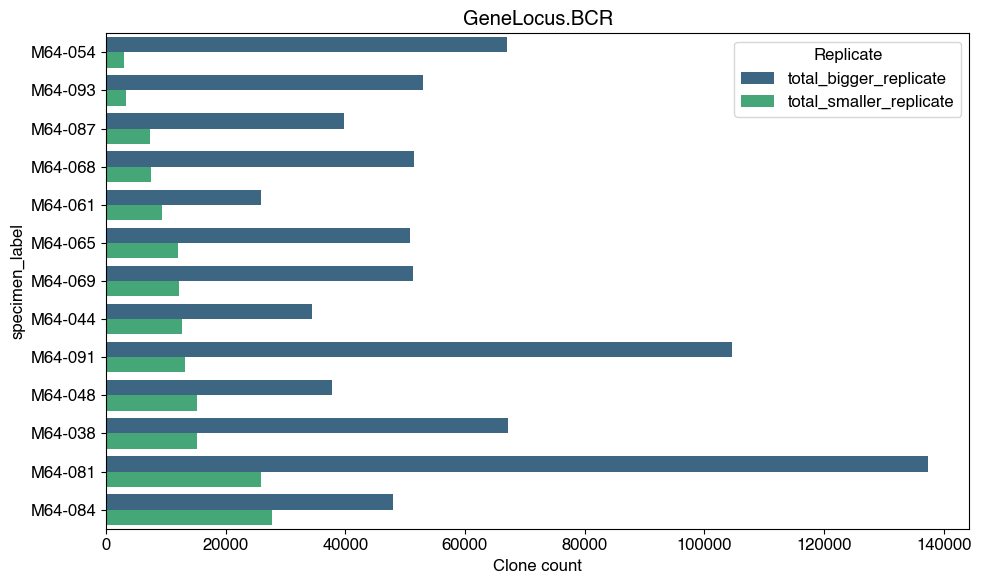

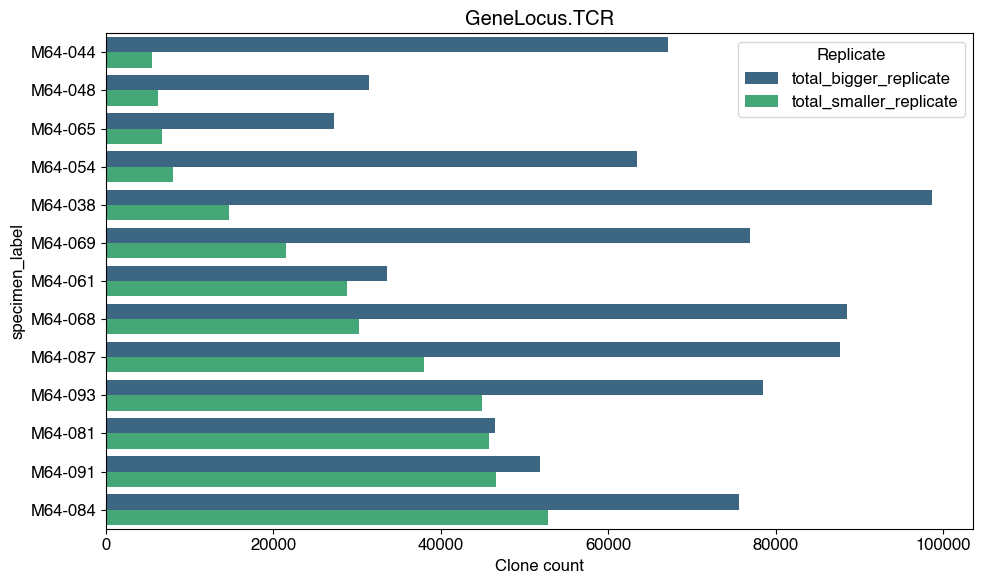

In [40]:
# Plot counts for remaining, non-rejected specimens
specimen_isotype_counts_df_remaining = specimen_isotype_counts_df[
    ~specimen_isotype_counts_df.index.isin(rejected_specimens, level="specimen_label")
]

for gene_locus in config.gene_loci_used:
    # Sort so that higher-count replicate comes before lower-count replicate
    totals_sorted = (
        specimen_isotype_counts_df_remaining.rename(
            columns={f"total_{gene_locus.name}": "total"}
        )
        .reset_index()
        .sort_values(by=["specimen_label", "total"], ascending=[True, False])
    )

    # Group by specimen_label and create the two value columns, one per replicate
    totals_transformed = (
        totals_sorted.groupby("specimen_label")["total"].apply(list).apply(pd.Series)
    )
    totals_transformed.columns = ["total_bigger_replicate", "total_smaller_replicate"]

    # Reset index to make 'specimen_label' a column again
    totals_transformed.reset_index(inplace=True)

    # Drop any rows where one replicate is empty. This removes single-replicate specimens.
    totals_transformed.dropna(axis=0, inplace=True)

    # Melt to long format. And sort so that specimens with lower smaller-replicate counts come first
    totals_long = pd.melt(
        totals_transformed.sort_values(["total_smaller_replicate"]),
        id_vars="specimen_label",
        var_name="Replicate",
        value_name="Clone count",
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=totals_long,
        y="specimen_label",
        x="Clone count",
        hue="Replicate",
        palette="viridis",
    )
    plt.title("Value1 and Value2 by specimen_label")
    plt.ylabel("specimen_label")
    plt.xlabel("Clone count")
    plt.title(gene_locus)
    plt.legend(title="Replicate")
    plt.tight_layout()

In [41]:
# Remove flagged specimens from the anndatas
print(adata_bcr.shape, adata_tcr.shape)

adata_bcr = adata_bcr[~adata_bcr.obs["specimen_label"].isin(rejected_specimens)]
adata_tcr = adata_tcr[~adata_tcr.obs["specimen_label"].isin(rejected_specimens)]

print(adata_bcr.shape, adata_tcr.shape)

(1855605, 640) (2356797, 640)


(1188235, 640) (1370361, 640)


In [42]:
# Featurize.
# Create a List[FeaturizedData]. Each extracted replicate will have one FeaturizedData object.
featurized_list: List[FeaturizedData] = []
for extracted_replicate_label, adata_by_locus in extract_anndatas_for_replicates(
    adata_bcr, adata_tcr
):
    # Featurize one replicate.
    # adata_by_locus has input anndatas wrapped as Dict[GeneLocus, anndata.AnnData], allowing use of single-locus or multi-locus metamodel.
    fd = clf.featurize(adata_by_locus)

    # Sanity check: Each FeaturizedData has only a single unique extracted replicate label, or is empty due to abstentions of which there would also only be 1
    assert (
        len(fd.sample_names) + len(fd.abstained_sample_names) == 1
    ), "metadata length plus abstained metadata length should equal 1"

    # We should set the index to be extracted replicate label, and make sure index is unique everywhere.

    # Change metadata index (and sample_names accordingly) to be extracted_replicate_label (which is not yet inside the metadata).
    # So extracted_replicate_label will be the index, and old index (specimen_label) is just another metadata column.
    # Do this for both the main metadata and abstained metadata
    fd.metadata = (
        fd.metadata.assign(extracted_replicate_label=extracted_replicate_label)
        .reset_index()
        .set_index("extracted_replicate_label")
    )
    fd.abstained_sample_metadata = (
        fd.abstained_sample_metadata.assign(
            extracted_replicate_label=extracted_replicate_label
        )
        .reset_index()
        .set_index("extracted_replicate_label")
    )

    fd.sample_names = fd.metadata.index
    fd.abstained_sample_names = fd.abstained_sample_metadata.index

    # Now add it to featurized_list
    featurized_list.append(fd)

    # garbage collect
    del adata_by_locus
    gc.collect()

{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 24 / 702 = 3.42%", "time": "2024-02-22T02:07:43.885552"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:08:33.142580"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 60 / 702 = 8.55%", "time": "2024-02-22T02:08:43.818108"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:09:15.694591"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 12 / 702 = 1.71%", "time": "2024-02-22T02:09:34.656147"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:10:25.278985"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 18 / 702 = 2.56%", "time": "2024-02-22T02:10:38.633655"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:11:16.736009"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 36 / 702 = 5.13%", "time": "2024-02-22T02:11:33.928194"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:12:09.786792"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 18 / 702 = 2.56%", "time": "2024-02-22T02:12:36.482747"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:13:19.310218"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 36 / 702 = 5.13%", "time": "2024-02-22T02:13:33.643646"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:14:13.610989"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 36 / 702 = 5.13%", "time": "2024-02-22T02:14:22.842845"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:14:58.329999"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 42 / 702 = 5.98%", "time": "2024-02-22T02:15:09.523153"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:15:43.202310"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 72 / 702 = 10.26%", "time": "2024-02-22T02:15:59.498383"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:16:41.805742"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 30 / 702 = 4.27%", "time": "2024-02-22T02:16:53.939475"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:17:34.458688"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 48 / 702 = 6.84%", "time": "2024-02-22T02:17:44.667382"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:18:18.158257"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 24 / 702 = 3.42%", "time": "2024-02-22T02:18:32.776289"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:19:14.654353"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 36 / 702 = 5.13%", "time": "2024-02-22T02:19:30.053148"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:20:08.647290"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 108 / 702 = 15.38%", "time": "2024-02-22T02:20:17.437077"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:20:45.280020"}


{"message": "Abstained specimens: {'M64-054'}", "time": "2024-02-22T02:20:47.515797"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 36 / 702 = 5.13%", "time": "2024-02-22T02:21:01.962007"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:21:38.800348"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 36 / 702 = 5.13%", "time": "2024-02-22T02:21:57.230919"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:22:41.229401"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 36 / 702 = 5.13%", "time": "2024-02-22T02:22:57.028615"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:23:30.897058"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 12 / 702 = 1.71%", "time": "2024-02-22T02:23:49.301715"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:24:35.411292"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 84 / 702 = 11.97%", "time": "2024-02-22T02:24:46.310380"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:25:16.021975"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 90 / 702 = 12.82%", "time": "2024-02-22T02:25:27.224245"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:25:57.939011"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 12 / 702 = 1.71%", "time": "2024-02-22T02:26:20.873035"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:27:03.680300"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 30 / 702 = 4.27%", "time": "2024-02-22T02:27:23.376263"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:28:05.850618"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 24 / 702 = 3.42%", "time": "2024-02-22T02:28:19.283255"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:28:54.351647"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 42 / 702 = 5.98%", "time": "2024-02-22T02:29:05.683953"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:29:38.727037"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 60 / 702 = 8.55%", "time": "2024-02-22T02:29:49.243408"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:30:24.304472"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 18 / 702 = 2.56%", "time": "2024-02-22T02:30:38.224946"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:31:17.843466"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 132 / 702 = 18.80%", "time": "2024-02-22T02:31:27.864347"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:31:58.541896"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 24 / 702 = 3.42%", "time": "2024-02-22T02:32:14.377687"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:32:58.444908"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 18 / 702 = 2.56%", "time": "2024-02-22T02:33:12.504634"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:33:50.650041"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 42 / 702 = 5.98%", "time": "2024-02-22T02:34:00.427426"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:34:39.573861"}


{"message": "Abstained specimens: {'M64-093'}", "time": "2024-02-22T02:34:41.833388"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 12 / 702 = 1.71%", "time": "2024-02-22T02:34:57.350198"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:35:43.586957"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 6 / 702 = 0.85%", "time": "2024-02-22T02:36:01.926702"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:36:50.067182"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 66 / 702 = 9.40%", "time": "2024-02-22T02:37:01.723680"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:37:35.410966"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 126 / 702 = 17.95%", "time": "2024-02-22T02:37:46.686939"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:38:14.453704"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 114 / 702 = 16.24%", "time": "2024-02-22T02:38:25.003682"}


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 0 / 168 = 0.00%", "time": "2024-02-22T02:38:55.491866"}


In [43]:
# Combine featurized_list into a single FeaturizedData object
featurized_all: FeaturizedData = FeaturizedData.concat(featurized_list)

In [44]:
# Sanity check: Each extracted replicate label appears only once in the combined FeaturizedData
# Confirm that all indexes are unique, from metadata and abstained metadata combined
assert (
    not pd.Series(
        np.hstack(
            [
                featurized_all.metadata.index,
                featurized_all.abstained_sample_metadata.index,
            ]
        )
    )
    .duplicated()
    .any()
), "Same extracted replicate label shared by multiple entries in featurized_list"

In [45]:
featurized_all.metadata.shape, featurized_all.abstained_sample_metadata.shape

((34, 15), (2, 15))

In [46]:
featurized_all.metadata.head()

,specimen_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name
extracted_replicate_label,,,,,,,,,,,,,,,
M66-M64-038,M64-038,61.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.053370,0.917168,0.029462,BFI-0003087,False,M,Healthy-StanfordBloodCenter_included-in-resequ...
M477-M64-048,M64-048,48.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.084900,0.872555,0.042544,BFI-0003097,False,F,Healthy-StanfordBloodCenter_included-in-resequ...
M66-M369-S001,M369-S001,73.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.198567,0.577210,0.224223,BFI-0007450,False,F,Covid19-buffycoat
M66-M371-S005,M371-S005,66.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.107749,0.813130,0.079121,BFI-0007481,False,M,Covid19-buffycoat
M66-M371-S024,M371-S024,77.0,Covid19,Covid19,Covid19,Admit,Covid19 - Sero-positive (Admit),NaN,0.107579,0.601890,0.290531,BFI-0007483,False,F,Covid19-buffycoat


In [47]:
featurized_all.abstained_sample_metadata.head()

,specimen_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name
extracted_replicate_label,,,,,,,,,,,,,,,
M477-M64-054,M64-054,63.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.105189,0.822149,0.072663,BFI-0003103,False,F,Healthy-StanfordBloodCenter_included-in-resequ...
M479-M64-093,M64-093,50.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.184208,0.731000,0.084793,BFI-0003142,False,M,Healthy-StanfordBloodCenter_included-in-resequ...


In [48]:
# According to the plots above, the two abstentions, M64-093 and M64-054, had fewer IgH clone counts than all other replicates. They were close to being rejected by the min-clone-count quality filters.

In [49]:
# Run model
results = crosseval.ModelSingleFoldPerformance(
    model_name=metamodel_name,
    fold_id=-1,
    y_true=featurized_all.y,
    clf=clf,
    X_test=featurized_all.X,
    fold_label_train="train_smaller",
    fold_label_test="extra_replicates",
    test_metadata=featurized_all.metadata,
    test_abstentions=featurized_all.abstained_sample_y,
    test_abstention_metadata=featurized_all.abstained_sample_metadata,
)

In [50]:
results.test_metadata["y_pred"] = results.y_pred

In [51]:
results.test_metadata.head()

,specimen_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name,y_pred
extracted_replicate_label,,,,,,,,,,,,,,,,
M66-M64-038,M64-038,61.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.053370,0.917168,0.029462,BFI-0003087,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background
M477-M64-048,M64-048,48.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.084900,0.872555,0.042544,BFI-0003097,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background
M66-M369-S001,M369-S001,73.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.198567,0.577210,0.224223,BFI-0007450,False,F,Covid19-buffycoat,Covid19
M66-M371-S005,M371-S005,66.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.107749,0.813130,0.079121,BFI-0007481,False,M,Covid19-buffycoat,Covid19
M66-M371-S024,M371-S024,77.0,Covid19,Covid19,Covid19,Admit,Covid19 - Sero-positive (Admit),NaN,0.107579,0.601890,0.290531,BFI-0007483,False,F,Covid19-buffycoat,Covid19


In [52]:
probas = pd.DataFrame(
    results.y_preds_proba,
    columns=[f"{i}_prob" for i in clf.classes_],
    index=results.test_metadata.index,
)
probas

,Covid19_prob,HIV_prob,Healthy/Background_prob,Influenza_prob,Lupus_prob,T1D_prob
extracted_replicate_label,,,,,,
M66-M64-038,0.013004,0.029691,0.883344,0.012221,0.041252,0.020487
M477-M64-048,0.122414,0.081268,0.581068,0.091439,0.075501,0.048310
M66-M369-S001,0.785177,0.020250,0.039033,0.005215,0.134838,0.015486
M66-M371-S005,0.873544,0.009160,0.039892,0.008157,0.056401,0.012847
M66-M371-S024,0.909702,0.022246,0.015760,0.003925,0.021882,0.026485
M66-M64-081,0.005330,0.024048,0.893925,0.024878,0.043861,0.007958
M479-M64-081,0.008403,0.021082,0.906595,0.015368,0.032358,0.016193
M66-M371-S004,0.824417,0.012513,0.029777,0.006243,0.103220,0.023831
M66-M371-S028,0.955558,0.003233,0.009609,0.001182,0.024867,0.005551


In [53]:
summary_results = pd.concat([results.test_metadata, probas], axis=1)
summary_results.head()

,specimen_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name,y_pred,Covid19_prob,HIV_prob,Healthy/Background_prob,Influenza_prob,Lupus_prob,T1D_prob
extracted_replicate_label,,,,,,,,,,,,,,,,,,,,,,
M66-M64-038,M64-038,61.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.053370,0.917168,0.029462,BFI-0003087,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.013004,0.029691,0.883344,0.012221,0.041252,0.020487
M477-M64-048,M64-048,48.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.084900,0.872555,0.042544,BFI-0003097,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.122414,0.081268,0.581068,0.091439,0.075501,0.048310
M66-M369-S001,M369-S001,73.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.198567,0.577210,0.224223,BFI-0007450,False,F,Covid19-buffycoat,Covid19,0.785177,0.020250,0.039033,0.005215,0.134838,0.015486
M66-M371-S005,M371-S005,66.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.107749,0.813130,0.079121,BFI-0007481,False,M,Covid19-buffycoat,Covid19,0.873544,0.009160,0.039892,0.008157,0.056401,0.012847
M66-M371-S024,M371-S024,77.0,Covid19,Covid19,Covid19,Admit,Covid19 - Sero-positive (Admit),NaN,0.107579,0.601890,0.290531,BFI-0007483,False,F,Covid19-buffycoat,Covid19,0.909702,0.022246,0.015760,0.003925,0.021882,0.026485


In [54]:
# Sort by index (extracted_replicate_label in reverse, so that M66 goes before M477) and by specimen_label
summary_results = (
    summary_results.reset_index()
    .sort_values(
        ["specimen_label", "extracted_replicate_label"], ascending=[True, False]
    )
    .set_index("extracted_replicate_label")
)
summary_results

,specimen_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name,y_pred,Covid19_prob,HIV_prob,Healthy/Background_prob,Influenza_prob,Lupus_prob,T1D_prob
extracted_replicate_label,,,,,,,,,,,,,,,,,,,,,,
M66-M369-S001,M369-S001,73.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.198567,0.577210,0.224223,BFI-0007450,False,F,Covid19-buffycoat,Covid19,0.785177,0.020250,0.039033,0.005215,0.134838,0.015486
M66-M371-S004,M371-S004,64.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.152434,0.587124,0.260442,BFI-0007453,False,M,Covid19-buffycoat,Covid19,0.824417,0.012513,0.029777,0.006243,0.103220,0.023831
M66-M371-S005,M371-S005,66.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.107749,0.813130,0.079121,BFI-0007481,False,M,Covid19-buffycoat,Covid19,0.873544,0.009160,0.039892,0.008157,0.056401,0.012847
M66-M371-S009,M371-S009,36.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.223082,0.460302,0.316616,BFI-0007484,False,M,Covid19-buffycoat,Covid19,0.916174,0.004363,0.015495,0.002268,0.051155,0.010545
M66-M371-S011,M371-S011,45.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.021591,0.933982,0.044427,BFI-0007485,False,F,Covid19-buffycoat,Covid19,0.867107,0.010862,0.018292,0.003792,0.082836,0.017111
M66-M371-S015,M371-S015,40.0,Covid19,Covid19,Covid19,ICU,Covid19 - Sero-positive (ICU),NaN,0.151762,0.630298,0.217940,BFI-0007480,False,F,Covid19-buffycoat,Covid19,0.855185,0.006327,0.023025,0.003644,0.101478,0.010342
M66-M371-S023,M371-S023,88.0,Covid19,Covid19,Covid19,Admit,Covid19 - Sero-positive (Admit),NaN,0.283706,0.591165,0.125128,BFI-0007482,False,F,Covid19-buffycoat,Covid19,0.948705,0.006794,0.015922,0.002263,0.016701,0.009615
M66-M371-S024,M371-S024,77.0,Covid19,Covid19,Covid19,Admit,Covid19 - Sero-positive (Admit),NaN,0.107579,0.601890,0.290531,BFI-0007483,False,F,Covid19-buffycoat,Covid19,0.909702,0.022246,0.015760,0.003925,0.021882,0.026485
M66-M371-S028,M371-S028,69.0,Covid19,Covid19,Covid19,Admit,Covid19 - Sero-positive (Admit),NaN,0.218636,0.609033,0.172330,BFI-0007486,False,F,Covid19-buffycoat,Covid19,0.955558,0.003233,0.009609,0.001182,0.024867,0.005551


In [55]:
# Export summary_results
summary_results.to_csv(
    clf.output_base_dir / f"{clf.model_file_prefix}.healthy_replicates.ridge_cv.tsv",
    sep="\t",
)

In [56]:
# Filter summary_results down to specimens with multiple replicates only
replicates = summary_results.loc[
    summary_results["specimen_label"].isin(
        summary_results["specimen_label"].value_counts().loc[lambda x: x > 1].index
    )
].copy()
replicates

,specimen_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name,y_pred,Covid19_prob,HIV_prob,Healthy/Background_prob,Influenza_prob,Lupus_prob,T1D_prob
extracted_replicate_label,,,,,,,,,,,,,,,,,,,,,,
M66-M64-038,M64-038,61.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.053370,0.917168,0.029462,BFI-0003087,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.013004,0.029691,0.883344,0.012221,0.041252,0.020487
M477-M64-038,M64-038,61.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.053370,0.917168,0.029462,BFI-0003087,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Influenza,0.199058,0.155249,0.113658,0.321326,0.099131,0.111578
M66-M64-044,M64-044,22.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.052188,0.877930,0.069881,BFI-0003093,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.005003,0.009103,0.958459,0.006067,0.015559,0.005809
M477-M64-044,M64-044,22.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.052188,0.877930,0.069881,BFI-0003093,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.119747,0.171560,0.557416,0.069882,0.045378,0.036018
M66-M64-048,M64-048,48.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.084900,0.872555,0.042544,BFI-0003097,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.013359,0.019752,0.927542,0.005938,0.019607,0.013802
M477-M64-048,M64-048,48.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.084900,0.872555,0.042544,BFI-0003097,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.122414,0.081268,0.581068,0.091439,0.075501,0.048310
M66-M64-061,M64-061,63.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.090751,0.876827,0.032421,BFI-0003110,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.016270,0.017595,0.894124,0.018647,0.040003,0.013362
M479-M64-061,M64-061,63.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.090751,0.876827,0.032421,BFI-0003110,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.029235,0.016593,0.816821,0.061748,0.030240,0.045364
M66-M64-065,M64-065,26.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Asian,0.112299,0.837525,0.050176,BFI-0003114,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.001626,0.004563,0.968247,0.003106,0.020633,0.001826


In [57]:
# Which studies did these replicates come from?
replicates.study_name.value_counts()

Healthy-StanfordBloodCenter_included-in-resequencing    22
Name: study_name, dtype: int64

In [58]:
# Important for below code: All specimens with replicates had exactly 2 replicates
assert all(replicates.groupby("specimen_label").size() == 2)

In [59]:
# Split into replicate1 and replicate2 dataframes
df1 = (
    replicates.drop_duplicates(subset="specimen_label", keep="first")
    .reset_index()
    .set_index("specimen_label")
)
df2 = (
    replicates.drop_duplicates(subset="specimen_label", keep="last")
    .reset_index()
    .set_index("specimen_label")
    # Make sure they have matching index
    .loc[df1.index]
)
color = df1["disease"]
assert df1.shape[0] == df2.shape[0]

In [60]:
# Sanity check the extracted_replicate_label's in each dataframe

In [61]:
df1

,extracted_replicate_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name,y_pred,Covid19_prob,HIV_prob,Healthy/Background_prob,Influenza_prob,Lupus_prob,T1D_prob
specimen_label,,,,,,,,,,,,,,,,,,,,,,
M64-038,M66-M64-038,61.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.053370,0.917168,0.029462,BFI-0003087,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.013004,0.029691,0.883344,0.012221,0.041252,0.020487
M64-044,M66-M64-044,22.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.052188,0.877930,0.069881,BFI-0003093,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.005003,0.009103,0.958459,0.006067,0.015559,0.005809
M64-048,M66-M64-048,48.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.084900,0.872555,0.042544,BFI-0003097,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.013359,0.019752,0.927542,0.005938,0.019607,0.013802
M64-061,M66-M64-061,63.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.090751,0.876827,0.032421,BFI-0003110,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.016270,0.017595,0.894124,0.018647,0.040003,0.013362
M64-065,M66-M64-065,26.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Asian,0.112299,0.837525,0.050176,BFI-0003114,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.001626,0.004563,0.968247,0.003106,0.020633,0.001826
M64-068,M66-M64-068,54.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.119946,0.779775,0.100280,BFI-0003117,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.018473,0.010140,0.919825,0.008295,0.012683,0.030583
M64-069,M66-M64-069,55.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Asian,0.148991,0.736639,0.114369,BFI-0003118,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.020833,0.021634,0.905264,0.009723,0.020370,0.022176
M64-081,M66-M64-081,67.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Hispanic/Latino,0.140702,0.808022,0.051276,BFI-0003130,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.005330,0.024048,0.893925,0.024878,0.043861,0.007958
M64-084,M66-M64-084,52.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.088505,0.829384,0.082111,BFI-0003133,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.002084,0.003728,0.983168,0.003323,0.005460,0.002237


In [62]:
df2

,extracted_replicate_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name,y_pred,Covid19_prob,HIV_prob,Healthy/Background_prob,Influenza_prob,Lupus_prob,T1D_prob
specimen_label,,,,,,,,,,,,,,,,,,,,,,
M64-038,M477-M64-038,61.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.053370,0.917168,0.029462,BFI-0003087,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Influenza,0.199058,0.155249,0.113658,0.321326,0.099131,0.111578
M64-044,M477-M64-044,22.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.052188,0.877930,0.069881,BFI-0003093,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.119747,0.171560,0.557416,0.069882,0.045378,0.036018
M64-048,M477-M64-048,48.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.084900,0.872555,0.042544,BFI-0003097,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.122414,0.081268,0.581068,0.091439,0.075501,0.048310
M64-061,M479-M64-061,63.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.090751,0.876827,0.032421,BFI-0003110,False,F,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.029235,0.016593,0.816821,0.061748,0.030240,0.045364
M64-065,M477-M64-065,26.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Asian,0.112299,0.837525,0.050176,BFI-0003114,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.050853,0.050738,0.702617,0.134724,0.030098,0.030970
M64-068,M479-M64-068,54.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV+,Asian,0.119946,0.779775,0.100280,BFI-0003117,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.035748,0.021557,0.653370,0.047431,0.044572,0.197321
M64-069,M479-M64-069,55.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Asian,0.148991,0.736639,0.114369,BFI-0003118,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Covid19,0.326213,0.050675,0.271648,0.035859,0.062604,0.253001
M64-081,M479-M64-081,67.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Hispanic/Latino,0.140702,0.808022,0.051276,BFI-0003130,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.008403,0.021082,0.906595,0.015368,0.032358,0.016193
M64-084,M479-M64-084,52.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - CMV-,Caucasian,0.088505,0.829384,0.082111,BFI-0003133,False,M,Healthy-StanfordBloodCenter_included-in-resequ...,Healthy/Background,0.004551,0.009205,0.960584,0.010124,0.010501,0.005035


In [63]:
# List of diseases or conditions to compare
columns = [col for col in replicates.columns if "_prob" in col]
columns

['Covid19_prob',
 'HIV_prob',
 'Healthy/Background_prob',
 'Influenza_prob',
 'Lupus_prob',
 'T1D_prob']

In [64]:
def concordance_correlation_coefficient(y_true, y_pred):
    pearson_corr = pearsonr(y_true, y_pred)[0]
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    return (2 * pearson_corr * mean_true * mean_pred) / (
        var_true + var_pred + (mean_true - mean_pred) ** 2
    )

In [65]:
# For each disease, correlation of P(disease) vector for all replicate1's versus P(disease) vector for all replicate2's
stats_df = {}

for column in columns:
    y_true = df1[column]
    y_pred = df2[column]

    stats_df[column] = {
        "Pearson": pearsonr(y_true, y_pred)[0],
        "Spearman": spearmanr(y_true, y_pred).correlation,
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "CCC": concordance_correlation_coefficient(y_true, y_pred),
    }

stats_df = pd.DataFrame.from_dict(stats_df, orient="index")
stats_df

,Pearson,Spearman,RMSE,CCC
Covid19_prob,0.570462,0.436364,0.121079,0.060560
HIV_prob,0.353616,0.427273,0.067480,0.113834
Healthy/Background_prob,0.502379,0.427273,0.368490,4.227490
Influenza_prob,0.022833,0.009091,0.108785,0.002727
Lupus_prob,0.300314,0.327273,0.036036,0.398462
T1D_prob,0.834130,0.736364,0.094188,0.142459


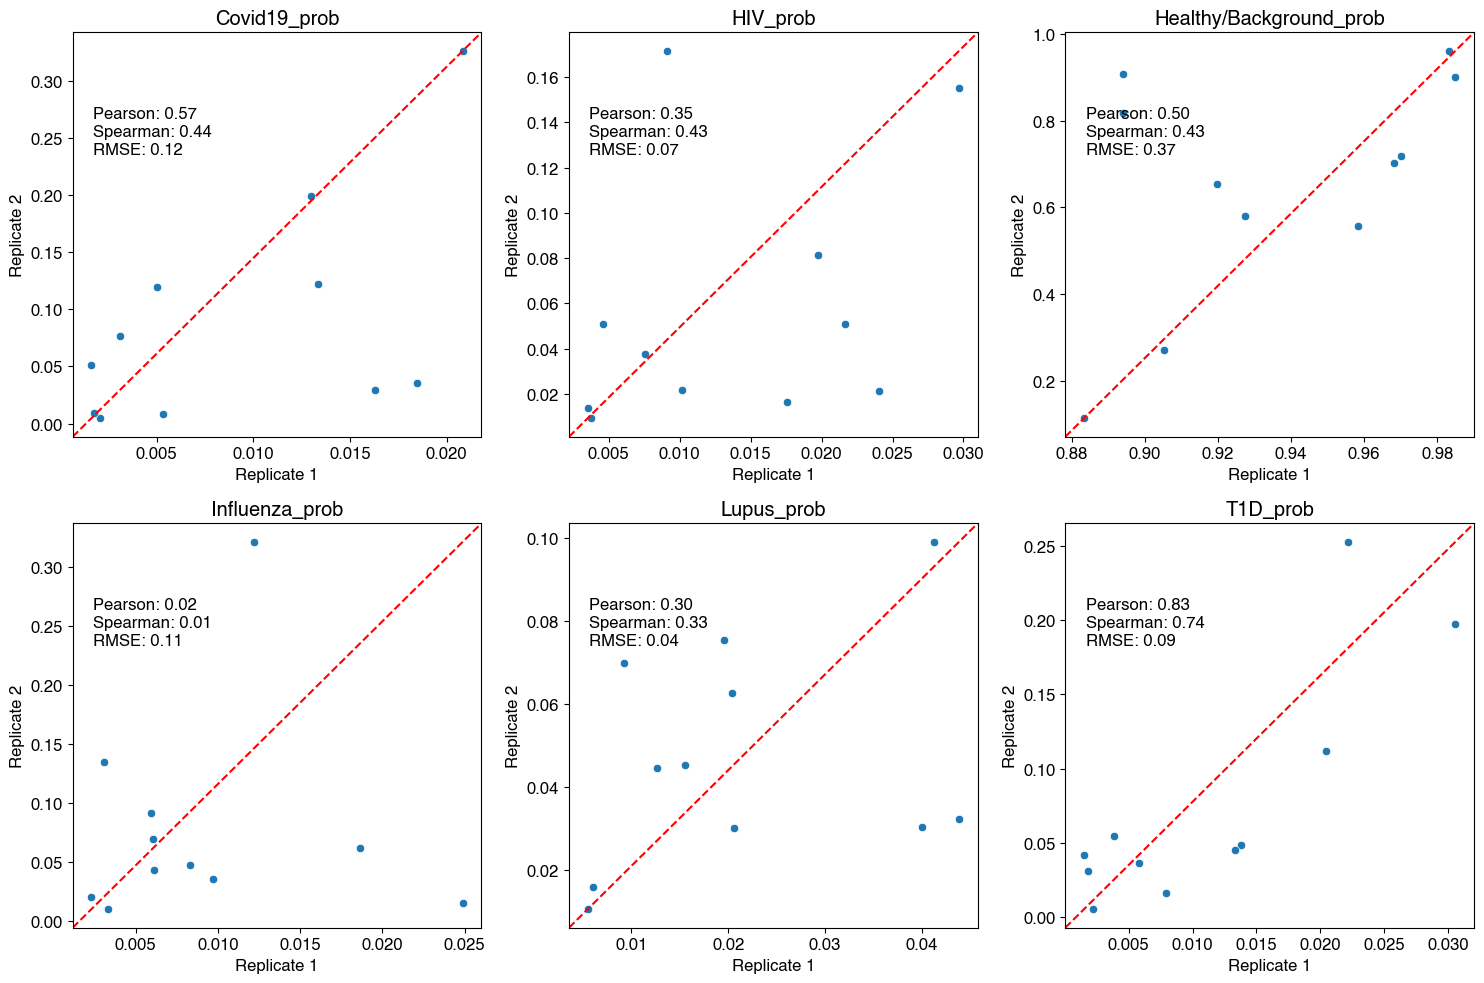

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, column in enumerate(columns):
    sns.scatterplot(x=df1[column], y=df2[column], ax=axs[i], legend=(i == 0))
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color="red", linestyle="--")
    axs[i].set_title(column)
    axs[i].set_xlabel("Replicate 1")
    axs[i].set_ylabel("Replicate 2")

    # Annotate subplot with statistics
    stats = stats_df.loc[column]
    annotation = f"Pearson: {stats['Pearson']:.2f}\nSpearman: {stats['Spearman']:.2f}\nRMSE: {stats['RMSE']:.2f}"
    axs[i].annotate(annotation, xy=(0.05, 0.7), xycoords="axes fraction")

plt.tight_layout()
plt.show()

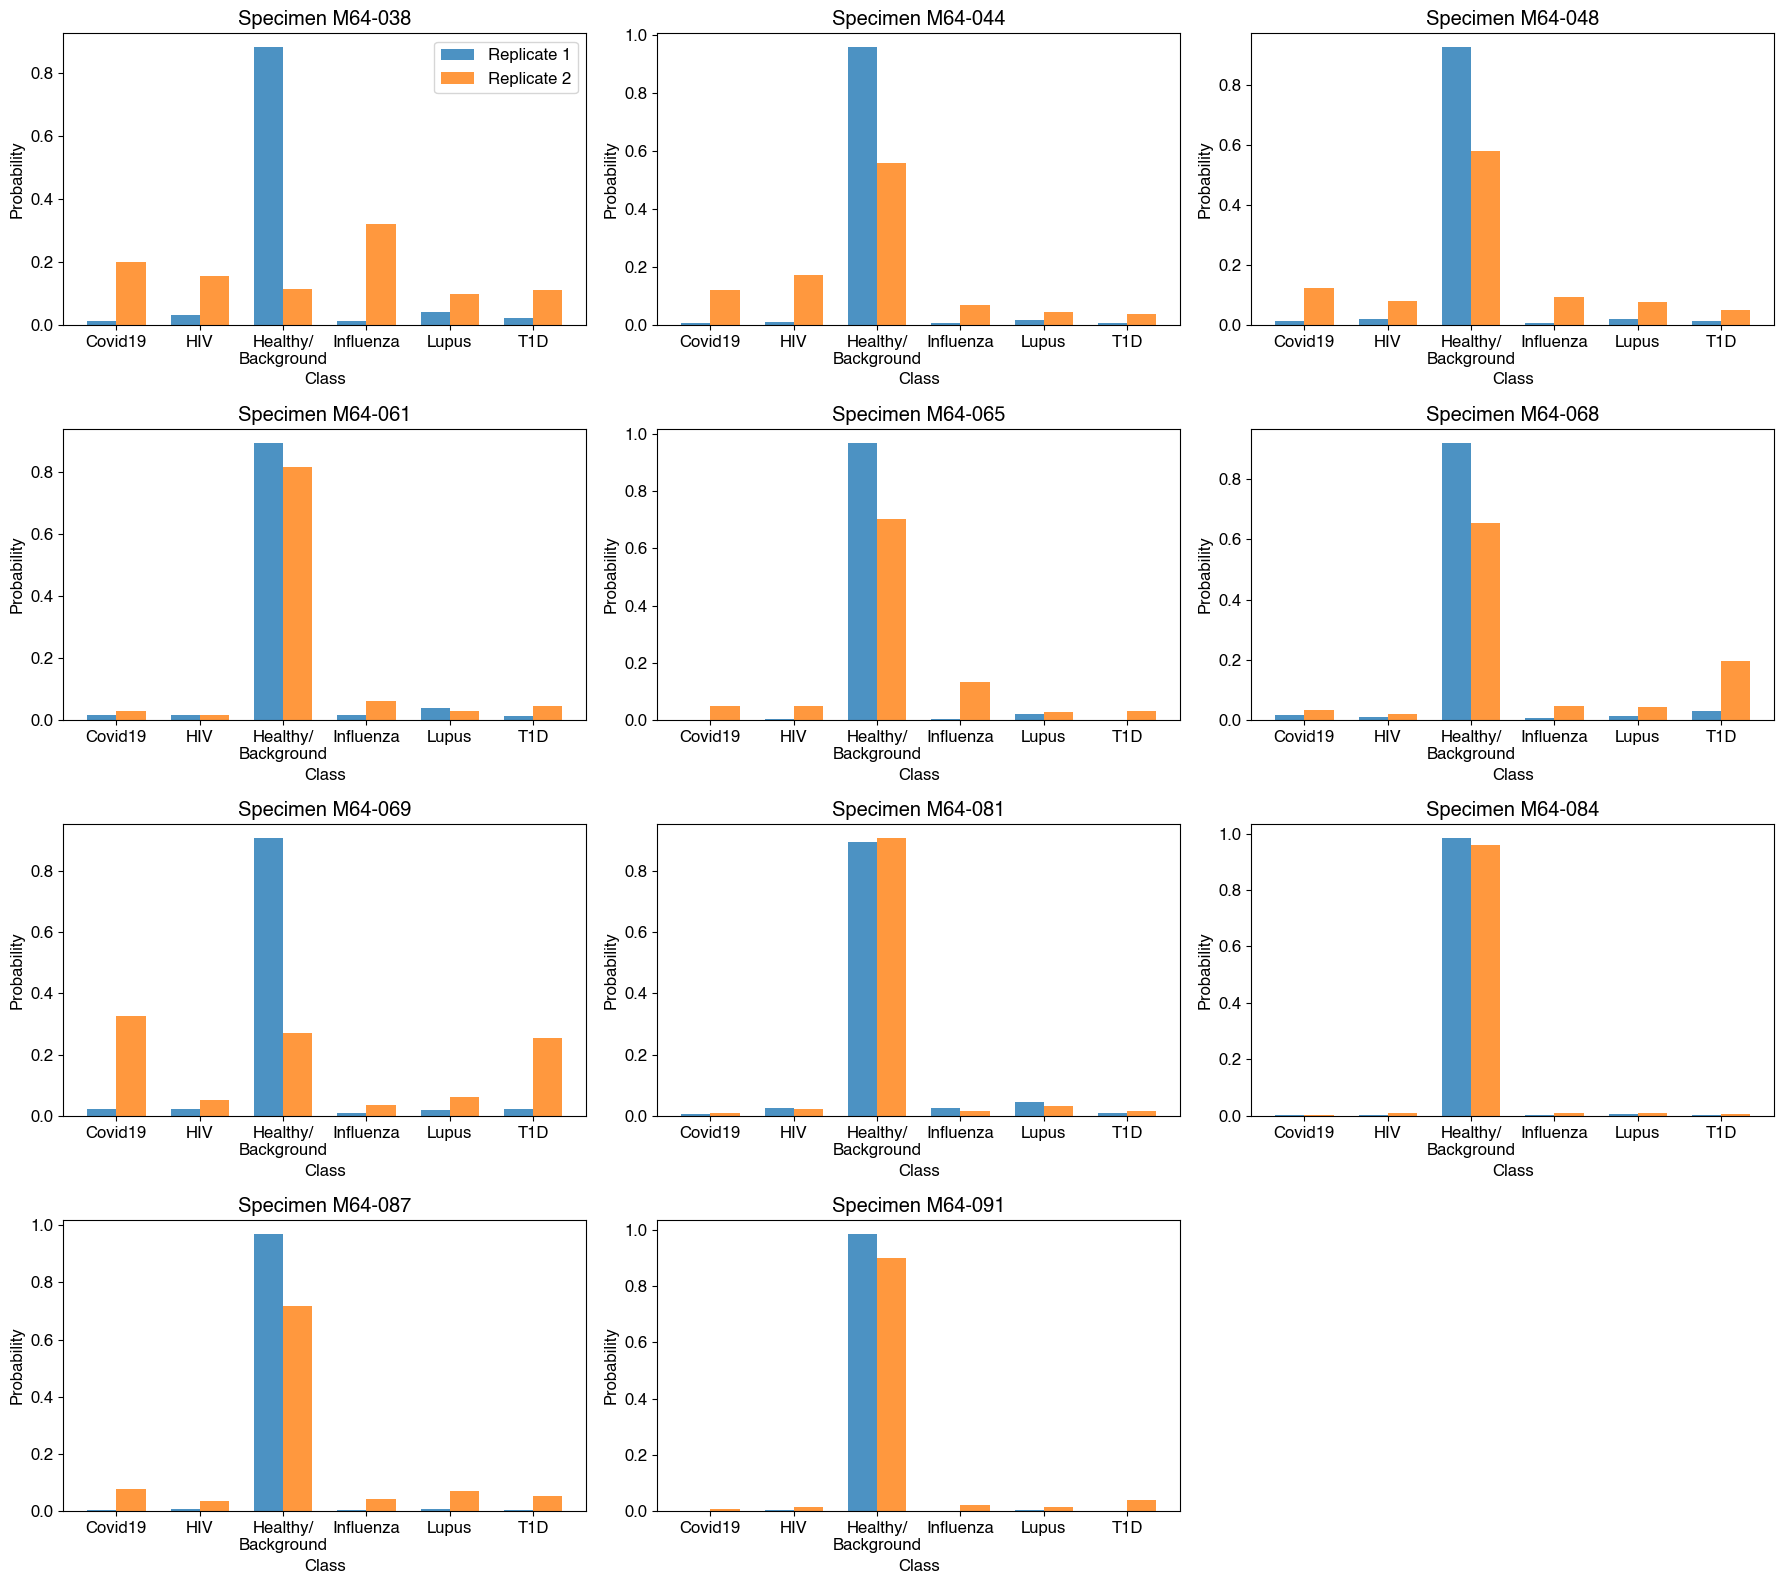

In [67]:
# Plot per sample:

# Determine layout dimensions for subplots
num_samples = len(df1)
nrows = int(np.ceil(np.sqrt(num_samples)))
ncols = int(np.ceil(num_samples / nrows))

# Set base dimensions for each subplot
base_width = 6
base_height = 4

# Calculate total dimensions for the entire figure
fig_width = base_width * ncols
fig_height = base_height * nrows

# Create figure and axis objects
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))
axs = axs.ravel()

# Loop through each sample to populate subplots
for idx, sample in enumerate(df1.index):
    ax = axs[idx]

    width = 0.35  # Width of the bars
    r1 = np.arange(len(columns))  # Positions of bars for Replicate 1
    r2 = [x + width for x in r1]  # Positions of bars for Replicate 2

    # Plotting bars for each replicate
    bars1 = ax.bar(
        r1, df1.loc[sample, columns].values, width=width, label="Replicate 1", alpha=0.8
    )
    bars2 = ax.bar(
        r2, df2.loc[sample, columns].values, width=width, label="Replicate 2", alpha=0.8
    )

    # Labeling, title, and legend
    ax.set_xlabel("Class")
    ax.set_ylabel("Probability")
    ax.set_title(f"Specimen {sample}")
    ax.set_xticks([r + width / 2 for r in range(len(columns))])
    ax.set_xticklabels(
        [s.replace("_prob", "") for s in columns]
    )  # , rotation=45, ha="right")
    genetools.plots.wrap_tick_labels(
        ax=ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
    )
    if idx == 0:
        ax.legend()

# Hide any remaining empty subplots
for idx in range(num_samples, nrows * ncols):
    axs[idx].axis("off")

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

In [68]:
assert df1.shape[0] == df2.shape[0] == replicates.shape[0] / 2

In [69]:
# replicates["first_replicate"] = replicates.index.isin(
#     replicates.drop_duplicates(subset="specimen_label", keep="first").index
# )
replicates["first_replicate"] = replicates.index.isin(
    df1["extracted_replicate_label"].values
)
replicates["replicate_num"] = replicates["first_replicate"].apply(
    lambda x: 1 if x else 2
)
replicates[["specimen_label", "first_replicate", "replicate_num"]]

,specimen_label,first_replicate,replicate_num
extracted_replicate_label,,,
M66-M64-038,M64-038,True,1
M477-M64-038,M64-038,False,2
M66-M64-044,M64-044,True,1
M477-M64-044,M64-044,False,2
M66-M64-048,M64-048,True,1
M477-M64-048,M64-048,False,2
M66-M64-061,M64-061,True,1
M479-M64-061,M64-061,False,2
M66-M64-065,M64-065,True,1


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Covid19_prob'),
  Text(1, 0, 'HIV_prob'),
  Text(2, 0, 'Healthy/Background_prob'),
  Text(3, 0, 'Influenza_prob'),
  Text(4, 0, 'Lupus_prob'),
  Text(5, 0, 'T1D_prob')])

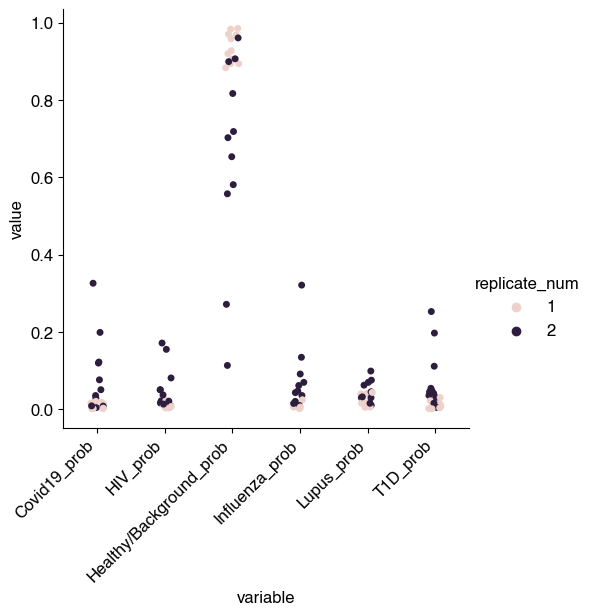

In [70]:
df = replicates.melt(id_vars=["replicate_num", "specimen_label"], value_vars=columns)
sns.catplot(x="variable", y="value", hue="replicate_num", data=df)
plt.xticks(rotation=45, ha="right")

,Pearson,Spearman,RMSE,CCC
M64-038,-0.329503,-0.714286,0.353551,-0.168339
M64-069,0.399284,0.542857,0.303127,0.179842
M64-044,0.966202,0.428571,0.185413,0.339570
M64-068,0.970020,0.600000,0.130242,0.327877
M64-065,0.988226,0.142857,0.124751,0.293205
M64-048,0.992614,0.142857,0.156709,0.366087
M64-061,0.998201,0.485714,0.038992,0.290867
M64-087,0.998383,0.200000,0.113439,0.291588
M64-091,0.999452,0.257143,0.039853,0.230033
M64-081,0.999777,0.828571,0.008844,0.257750


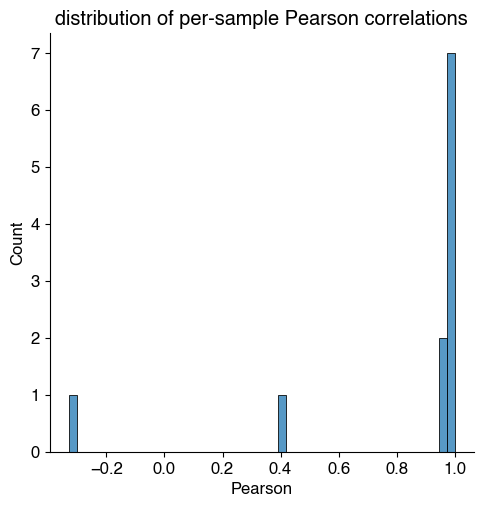

In [71]:
stats_df = {}

for sample in df1.index:
    y_true_sample = df1.loc[sample, columns]
    y_pred_sample = df2.loc[sample, columns]

    stats_df[sample] = {
        "Pearson": pearsonr(y_true_sample, y_pred_sample)[0],
        "Spearman": spearmanr(y_true_sample, y_pred_sample).correlation,
        "RMSE": np.sqrt(mean_squared_error(y_true_sample, y_pred_sample)),
        "CCC": concordance_correlation_coefficient(y_true_sample, y_pred_sample),
    }

stats_df = pd.DataFrame.from_dict(stats_df, orient="index")

sns.displot(x="Pearson", data=stats_df)
plt.title("distribution of per-sample Pearson correlations")
stats_df.sort_values("Pearson")

In [72]:
# How many specimens had Pearson correlation over 90% between the predicted class probability vectors for their two replicates?
(stats_df.Pearson > 0.9).sum(), stats_df.shape[0]

(9, 11)

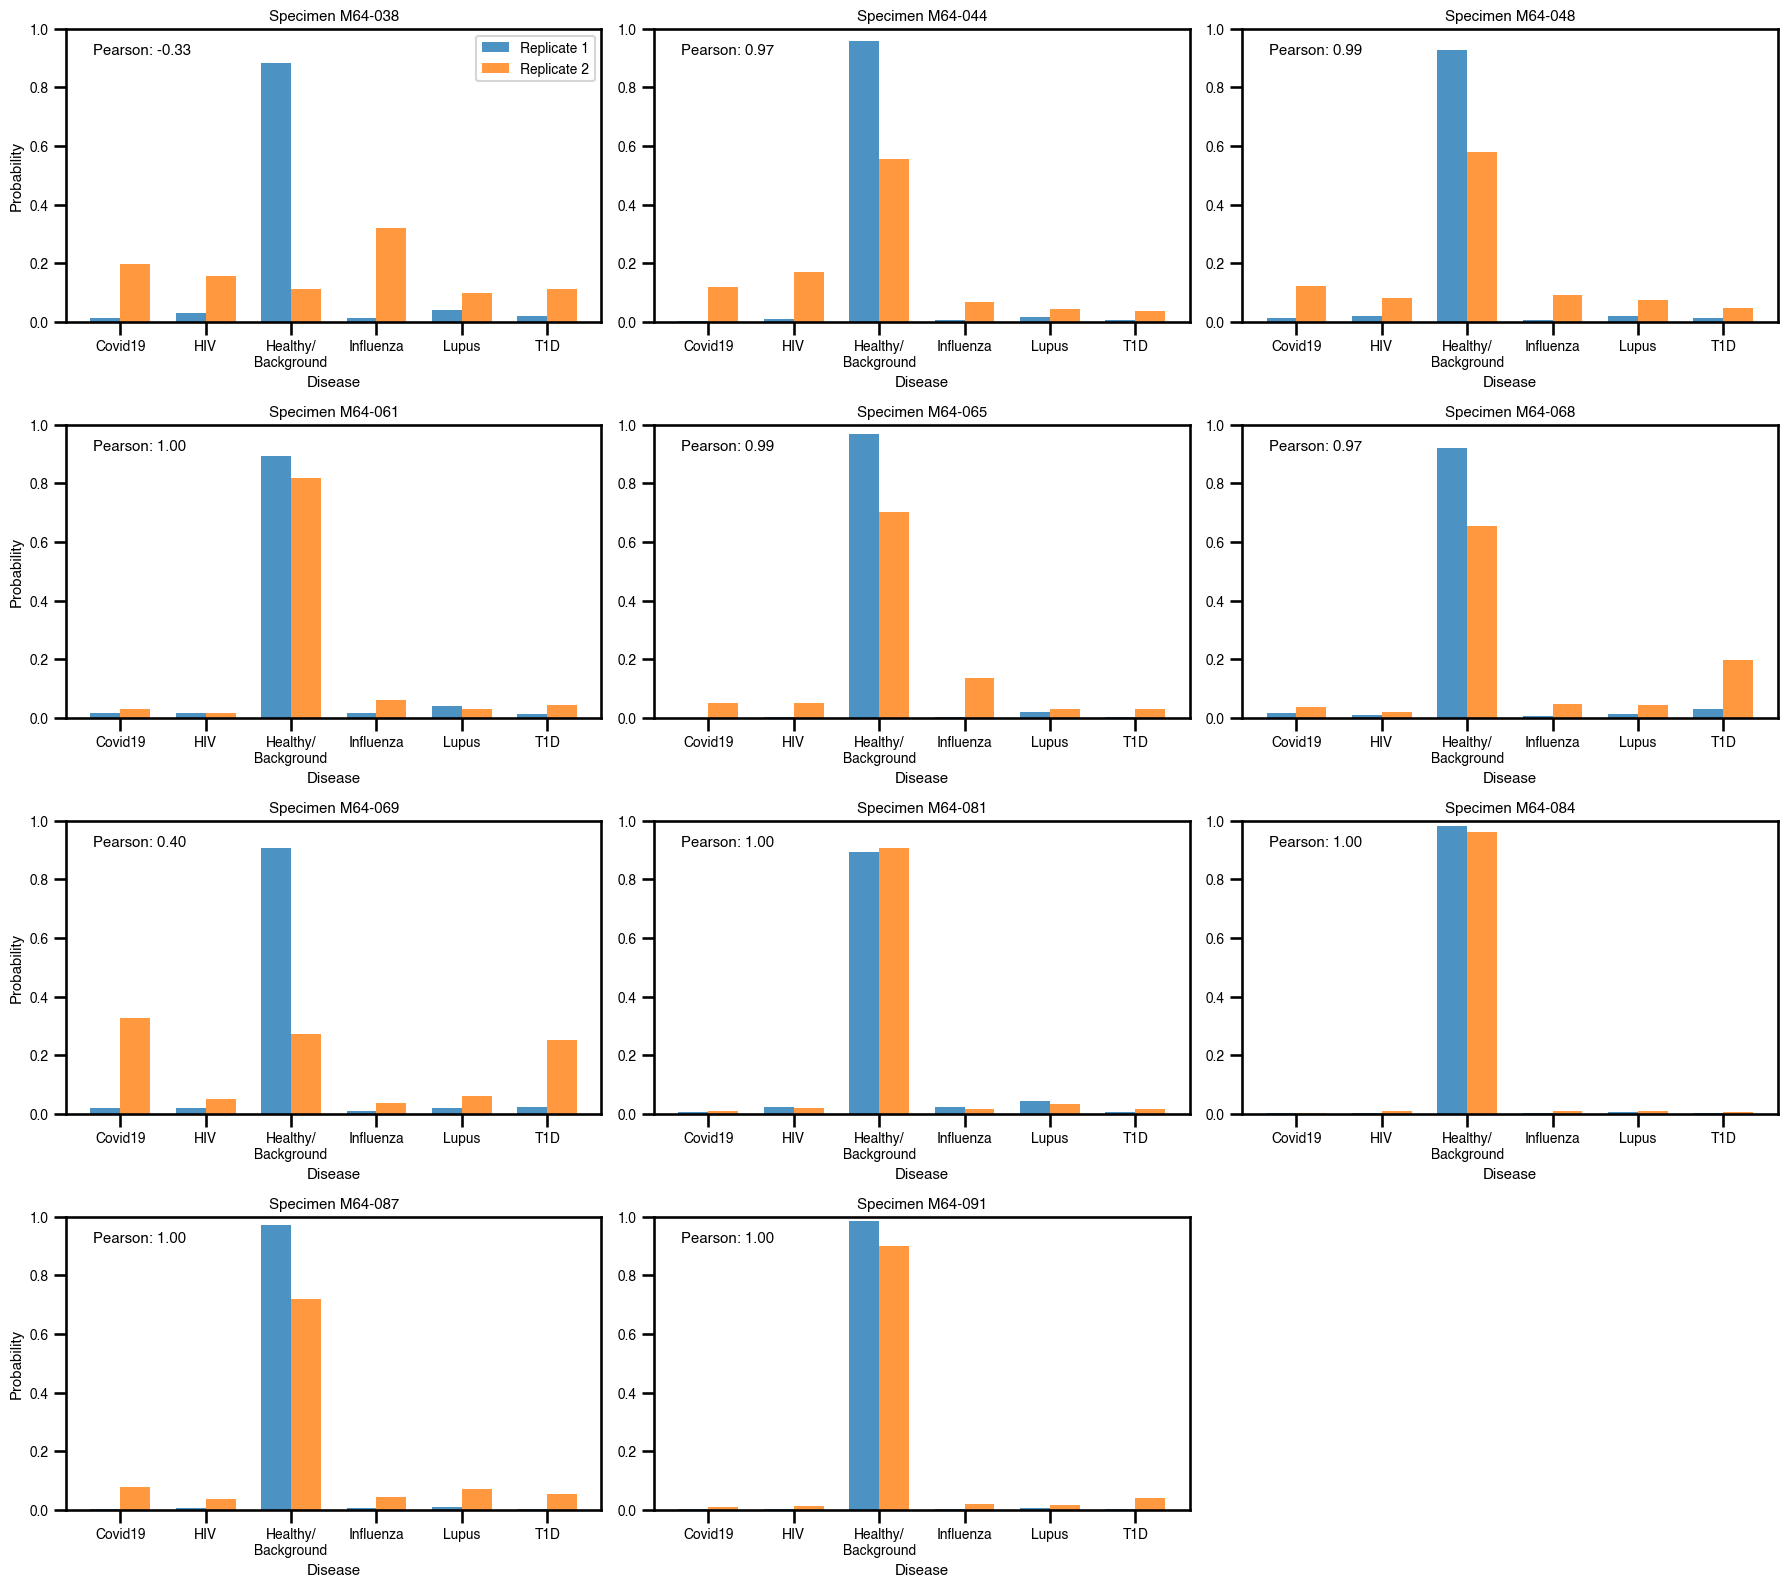

In [73]:
with sns.plotting_context(
    "talk",
    # Adjust font_scale as needed for further customization
    font_scale=0.6,
):

    # Determine layout dimensions for subplots
    nrows = int(np.ceil(np.sqrt(num_samples)))
    ncols = int(np.ceil(num_samples / nrows))

    # Set base dimensions for each subplot
    base_width = 6
    base_height = 4

    # Calculate total dimensions for the entire figure
    fig_width = base_width * ncols
    fig_height = base_height * nrows

    # Create figure and axis objects
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))
    axs = axs.ravel()

    # Loop through each sample to populate subplots
    for idx, sample in enumerate(df1.index):
        ax = axs[idx]

        width = 0.35  # Width of the bars
        r1 = np.arange(len(columns))  # Positions of bars for Replicate 1
        r2 = [x + width for x in r1]  # Positions of bars for Replicate 2

        # Plotting bars for each replicate
        bars1 = ax.bar(
            r1,
            df1.loc[sample, columns].values,
            width=width,
            label="Replicate 1",
            alpha=0.8,
        )
        bars2 = ax.bar(
            r2,
            df2.loc[sample, columns].values,
            width=width,
            label="Replicate 2",
            alpha=0.8,
        )

        # Labeling, title, and legend
        ax.set_xlabel("Disease")
        if idx % ncols == 0:
            ax.set_ylabel("Probability")
        ax.set_title(f"Specimen {sample}")
        ax.set_xticks([r + width / 2 for r in range(len(columns))])
        # ax.set_xticklabels(columns, rotation=45, ha="right")
        ax.set_xticklabels([s.replace("_prob", "") for s in columns])
        genetools.plots.wrap_tick_labels(
            ax=ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
        )
        ax.set_ylim(0, 1)

        # Overlaying the statistics from stats_df onto the plot
        stats_text = f"Pearson: {stats_df.loc[sample, 'Pearson']:.2f}\n"
        # stats_text += f"Spearman: {stats_df.loc[sample, 'Spearman']:.2f}\n"
        # stats_text += f"RMSE: {stats_df.loc[sample, 'RMSE']:.2f}\n"
        ax.text(
            0.05,
            0.95,
            stats_text,
            transform=ax.transAxes,
            verticalalignment="top",
            # bbox=dict(boxstyle="round", facecolor="white", alpha=0.6),
        )

        if idx == 0:
            ax.legend()

    # Hide any remaining empty subplots
    for idx in range(num_samples, nrows * ncols):
        axs[idx].axis("off")

    # Adjust layout for better visibility
    plt.tight_layout()
    genetools.plots.savefig(
        fig,
        clf.output_base_dir
        / f"{clf.model_file_prefix}.healthy_replicates.ridge_cv.results_per_sample.png",
        dpi=300,
    )
    plt.show()

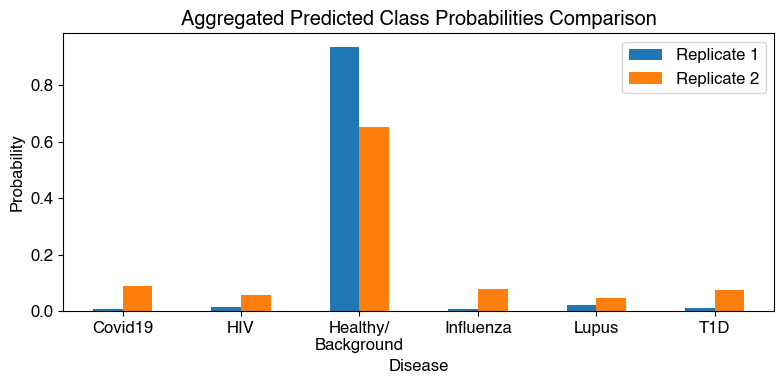

In [74]:
# This plot relies on Replicate 1 and Replicate 2 labels being set consistently across specimens to the old and new copies, respectively. So the df1, df2 split logic above must be checked carefully.

# Aggregating data
means_df1 = df1[columns].mean()
means_df2 = df2[columns].mean()

# Constructing a DataFrame for aggregated data
agg_data = pd.DataFrame({"Replicate 1": means_df1, "Replicate 2": means_df2})

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))
agg_data.plot(kind="bar", ax=ax)
plt.title("Aggregated Predicted Class Probabilities Comparison")
plt.ylabel("Probability")
plt.xlabel("Disease")
# plt.xticks(rotation=45)
ax.set_xticklabels(
    [lbl.get_text().replace("_prob", "") for lbl in ax.get_xticklabels()], rotation=0
)
genetools.plots.wrap_tick_labels(
    ax=ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
)
plt.tight_layout()
genetools.plots.savefig(
    fig,
    clf.output_base_dir
    / f"{clf.model_file_prefix}.healthy_replicates.ridge_cv.results_aggregate.png",
    dpi=300,
)

plt.show()

In [75]:
(df1["y_pred"] == df2["y_pred"]).value_counts()

True     9
False    2
Name: y_pred, dtype: int64

In [76]:
# Where do predictions disagree:
# (The syntax .loc[lambda x: x] or equivalently .loc[lambda x: x == True] simply filters down to true entries)
(df1["y_pred"] != df2["y_pred"]).loc[lambda x: x]

specimen_label
M64-038    True
M64-069    True
Name: y_pred, dtype: bool

In [77]:
# Among samples where the replicates agreed:
# What is the range of Pearson correlations between the two replicates' predicted class probability vectors
stats_df.loc[(df1["y_pred"] == df2["y_pred"]).loc[lambda x: x].index][
    "Pearson"
].describe()

count    9.000000
mean     0.990319
std      0.013214
min      0.966202
25%      0.988226
50%      0.998201
75%      0.999452
max      0.999991
Name: Pearson, dtype: float64